<a href="https://colab.research.google.com/github/rubycho/cv-notes/blob/master/CV03/CV03-3%20Traffic%20Sign%20with%20YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traffic Sign with YOLO

Today, let's detect traffic signs with YOLO.

Instead of using tensorflow implementation (CV03-2), we are simply using darknet to retrain the model.

Darknet provides an easy way to retrain YOLO!

### Previous setup code

In [1]:
# clone darknet and build
!git clone https://github.com/pjreddie/darknet.git
%cd darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5913, done.
remote: Total 5913 (delta 0), reused 0 (delta 0), pack-reused 5913
Receiving objects: 100% (5913/5913), 6.34 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (3918/3918), done.
/content/darknet


**IMPORTANT**

Please check the items below; or training will be really slow.

1. You should run colab notebook as **GPU** mode.
1. Before make, set GPU=1, OPENCV=1 on `Makefile`.

In [2]:
!make

# download pretrained weights
!wget https://pjreddie.com/media/files/darknet53.conv.74

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result 

## Prepare dataset from kaggle

You need a kaggle account for downloading a traffic sign dataset.

Check the link for [API Credentials](https://github.com/Kaggle/kaggle-api#api-credentials).

This dataset has 4 classes.

In [ ]:
# set kaggle env
%env KAGGLE_USERNAME=USERNAME_WITHOUT_QUOTES
%env KAGGLE_KEY=KEY_WITHOUT_QUOTES

In [4]:
# download dataset
!kaggle datasets download -d valentynsichkar/traffic-signs-dataset-in-yolo-format
!unzip -d dataset -q traffic-signs-dataset-in-yolo-format.zip

 93% 233M/250M [00:04<00:00, 52.9MB/s]
100% 250M/250M [00:04<00:00, 63.5MB/s]


In [5]:
!cp dataset/yolov3_ts_test.cfg ./cfg/
!cp dataset/yolov3_ts_train.cfg ./cfg/

!mkdir ts
!cp -rf dataset/ts/ts/* ./ts/

In [6]:
def adjust_path(fpath: str, old: str, new: str):
  content = []
  with open(fpath, 'r') as f:
    for line in f.readlines():
      content.append(line.replace(old, new))

  with open(fpath, 'w') as f:
    f.write(''.join(content))

OLD_NAME = '/home/my_name/'
NEW_NAME = '/content/darknet/'

adjust_path('./dataset/train.txt', OLD_NAME, NEW_NAME)
adjust_path('./dataset/test.txt', OLD_NAME, NEW_NAME)
adjust_path('./dataset/ts_data.data', OLD_NAME, NEW_NAME)

In [7]:
!cp ./dataset/classes.names ./ts/
!cp ./dataset/train.txt ./ts/
!cp ./dataset/test.txt ./ts/
!cp ./dataset/ts_data.data ./ts/

# change coco.names
!cp -rf ./dataset/classes.names ./data/coco.names

### Train

Train the network until 900th epoch.

(when backup/yolov3_ts_train_900.weights is created)

In [ ]:
!./darknet detector train ts/ts_data.data cfg/yolov3_ts_train.cfg darknet53.conv.74

### Result

In [9]:
!wget https://github.com/rubycho/cv-notes/blob/master/CV03/yolo-test.jpg?raw=true -O yolo-test.jpg
!./darknet detect cfg/yolov3_ts_test.cfg backup/yolov3_ts_train_900.weights yolo-test.jpg

--2020-09-04 06:32:54--  https://github.com/rubycho/cv-notes/blob/master/CV03/yolo-test.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rubycho/cv-notes/raw/master/CV03/yolo-test.jpg [following]
--2020-09-04 06:32:54--  https://github.com/rubycho/cv-notes/raw/master/CV03/yolo-test.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rubycho/cv-notes/master/CV03/yolo-test.jpg [following]
--2020-09-04 06:32:54--  https://raw.githubusercontent.com/rubycho/cv-notes/master/CV03/yolo-test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

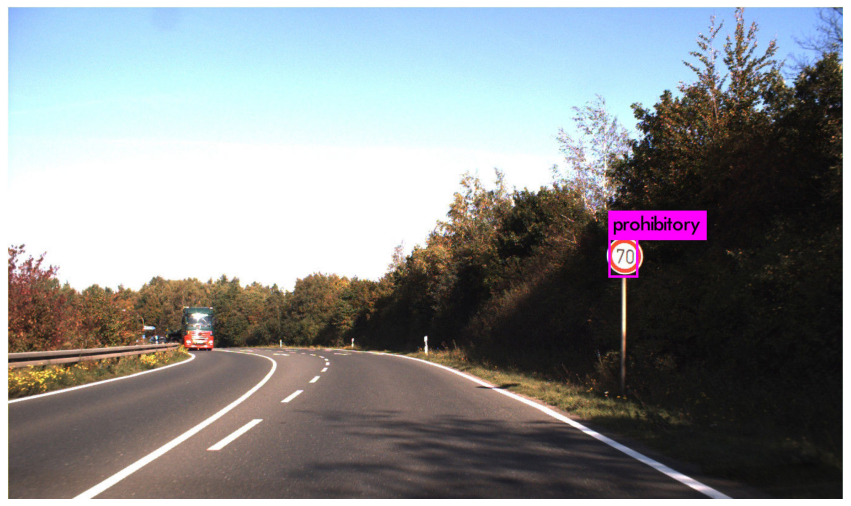

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg

img = mimg.imread('./predictions.jpg')
plt.figure(figsize=(15, 15))

plt.axis('off')
plt.imshow(img)

### For more information...

- Yolo Homepage; check `Training YOLO on VOC`: https://pjreddie.com/darknet/yolo/
- Darknet github repository: https://github.com/pjreddie/darknet
- Darknet github, forked repository by AlexeyAB; this repository gives guides how to train on custom yolo dataset: https://github.com/AlexeyAB/darknet
- Kaggle dataset: https://www.kaggle.com/valentynsichkar/traffic-signs-dataset-in-yolo-format
- Epochs Number Issue: https://github.com/ultralytics/yolov3/issues/559